# <span style="color: green"> Customer Segmentation Example </span>


In this notebook, we will explore customer segmentation using clustering techniques such as KMeans, DBSCAN, and Gaussian Mixture Models. We will use the provided dataset to perform the segmentation, evaluate the clustering results, and visualize the results.

In [1]:
%load_ext cuml.accel
import cuml
print("cuML version:", cuml.__version__)

import importlib.util

import cuml.cluster
print(dir(cuml.cluster))




cuML version: 25.12.00
['AgglomerativeClustering', 'DBSCAN', 'HDBSCAN', 'KMeans', 'SpectralClustering', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'agglomerative', 'dbscan', 'hdbscan', 'kmeans', 'spectral_clustering']


In [2]:
import cuml.metrics.cluster as cmc

dir(cmc)


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'adjusted_rand_index',
 'adjusted_rand_score',
 'completeness_score',
 'entropy',
 'homogeneity_score',
 'mutual_info_score',
 'silhouette_samples',
 'silhouette_score',
 'utils',
 'v_measure',
 'v_measure_score']

In [3]:
# # Importing Necessary Libraries
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
# from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture

# from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# from sklearn.neighbors import KernelDensity
# from ucimlrepo import fetch_ucirepo

In [4]:
# =========================
# GPU core
# =========================
import cudf
import cupy as cp

# =========================
# cuML (confirmed available)
# =========================
from cuml.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from cuml.cluster import (
    KMeans,
    DBSCAN,
    HDBSCAN,
    AgglomerativeClustering,
    SpectralClustering
)
from cuml.decomposition import PCA

# =========================
# CPU-only (by design)
# =========================
from sklearn.cluster import MeanShift

# =========================
# Utilities / plotting
# =========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

## <span style="color: Blue"> 1. Data Loading and Exploration </span>
In this chapter, we will load the dataset and perform initial data exploration to understand the structure and basic statistics.

In [5]:
# Fetch dataset (CPU)
online_retail = fetch_ucirepo(id=352)

X = online_retail.data.features
y = online_retail.data.targets

# Combine (CPU)
df = pd.concat([X, y], axis=1)


In [6]:
gdf = cudf.DataFrame.from_pandas(df)


le = LabelEncoder()

gdf['Country'] = le.fit_transform(gdf['Country'])

# Keep numeric columns only

gdf_num = gdf.select_dtypes(include=[np.number]).astype("float32")
# Handling missing values
gdf_num = gdf_num.fillna(gdf_num.mean())

/opt/conda/lib/python3.13/site-packages/cudf/core/dataframe.py:5641: FutureWarning: from_pandas is deprecated and will be removed in a future version. Use the DataFrame constructor instead.
  warnings.warn(


In [7]:
print(gdf_num.size)
gdf_num.head()

2167636


,Quantity,UnitPrice,CustomerID,Country
0,6.0,2.55,17850.0,36.0
1,6.0,3.39,17850.0,36.0
2,8.0,2.75,17850.0,36.0
3,6.0,3.39,17850.0,36.0
4,6.0,3.39,17850.0,36.0


In [8]:

data = gdf_num[
    (gdf_num['Quantity'] > 0) &
    (gdf_num['UnitPrice'] > 0)
].reset_index(drop=True)

data['log_Quantity'] = cp.log1p(data['Quantity'])
data['log_UnitPrice'] = cp.log1p(data['UnitPrice'])

data[['Quantity', 'UnitPrice']].describe()

# print(data.size)
# print(data.dtypes)
# data.head()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524109,35.915680
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330078


In [9]:
data.head()
print(data.dtypes)

Quantity         float32
UnitPrice        float32
CustomerID       float32
Country          float32
log_Quantity     float32
log_UnitPrice    float32
dtype: object


## <span style="color: Blue"> 2. Data Preprocessing </span>
In this section, we will preprocess the data by handling missing values, encoding categorical variables, and scaling the features.

In [10]:

#scaler = StandardScaler()
scaler = StandardScaler(output_type="cupy")
scaled_data = scaler.fit_transform(data.drop(['Quantity','UnitPrice'],axis=1))  # Dropping the non logged columns
# scaled_data = scaler.fit_transform(data)  # Drop non-numerical columns

## <span style="color: Blue"> 3. Clustering the Data</span>
Now that we have preprocessed the data, we will apply different clustering algorithms to segment the customers into groups.

In [11]:
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
data['KMeans_Cluster'] = kmeans_labels

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)
data['DBSCAN_Cluster'] = dbscan_labels

## had to change paramters because when computing the silhoute score it cause my memory to time out
# hdbscan = HDBSCAN(min_cluster_size=20)
# hdbscan_labels = hdbscan.fit_predict(scaled_data)
# data['HDBSCAN_Cluster'] = cudf.Series(hdbscan_labels)
hdbscan = HDBSCAN(
    min_cluster_size=50,
    min_samples=50,
    prediction_data=False,
    gen_min_span_tree=False,
    allow_single_cluster=True,
)
hdbscan_labels = hdbscan.fit_predict(scaled_data)
data['HDBSCAN_Cluster'] = cudf.Series(hdbscan_labels)


spectral = SpectralClustering(n_clusters=5, random_state=42)
spectral_labels = spectral.fit_predict(scaled_data)
data['Spectral_Cluster'] = cudf.Series(spectral_labels)

 
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)
data['GMM_Cluster'] =  cudf.Series(gmm_labels)

[2025-12-15 03:52:07.176] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 7737 -> 4051. Using the larger integer type might result in better performance
[2025-12-15 03:52:34.355] [CUML] [warning] Using data on device memory because knn_n_clusters = 1.


## <span style="color: Blue"> 4. Dimensionality Reduction and Visualization</span>
To better visualize the clusters, we will reduce the dimensionality of the data using PCA and plot the results.

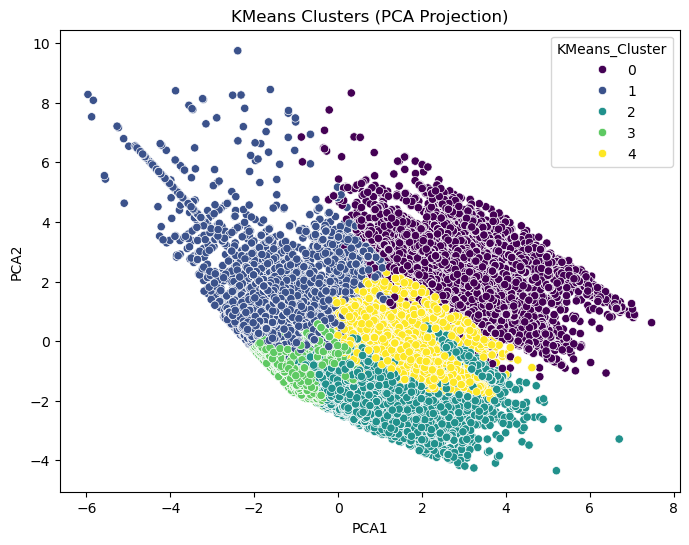

In [12]:
# pca = PCA(n_components=2)
# pca_components = pca.fit_transform(scaled_data)

# data['PCA1'] = cudf.Series(pca_components[:, 0])
# data['PCA2'] = cudf.Series(pca_components[:, 1])

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

data['PCA1'] = pca_components[:, 0]
data['PCA2'] = pca_components[:, 1]

# Visualize KMeans Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=data.to_pandas(), palette='viridis')
plt.title('KMeans Clusters (PCA Projection)')
plt.show()


## <span style="color: Blue">  5. Clustering Performance Evaluation</span>
In this section, we will evaluate the performance of the clustering algorithms using various metrics such as Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Score.

In [13]:
from cuml.metrics.cluster import silhouette_score, silhouette_samples


In [14]:
# Global silhouette score (works with cuDF or CuPy)
kmeans_sil_score = silhouette_score(scaled_data, kmeans_labels)

# # Per-sample silhouette values (REQUIRES CuPy)
# kmeans_sil_samples = silhouette_samples(scaled_data, kmeans_labels)

# # Attach to cuDF DataFrame
# data['KMeans_Silhouette'] = kmeans_sil_samples


In [15]:
# Create mask to remove noise points
dbscan_mask = dbscan_labels != -1

# Global silhouette score (ONLY non-noise points)
dbscan_sil_score = silhouette_score(
    scaled_data[dbscan_mask],
    dbscan_labels[dbscan_mask]
)

# # Per-sample silhouette values (ONLY non-noise points)
# dbscan_sil_samples = silhouette_samples(
#     scaled_data[dbscan_mask],
#     dbscan_labels[dbscan_mask]
# )

# # Initialize column with NaN
# data['DBSCAN_Silhouette'] = cp.nan

# # Assign silhouette values back to original rows
# data.loc[dbscan_mask, 'DBSCAN_Silhouette'] = dbscan_sil_samples



In [16]:
# Mask noise points (-1)
hdbscan_mask = hdbscan_labels != -1

# Global silhouette score (non-noise only)
hdbscan_sil_score = silhouette_score(
    scaled_data[hdbscan_mask],
    hdbscan_labels[hdbscan_mask]
)

# # Per-sample silhouette values
# hdbscan_sil_samples = silhouette_samples(
#     scaled_data[hdbscan_mask],
#     hdbscan_labels[hdbscan_mask]
# )

# # Initialize column with NaN
# data['HDBSCAN_Silhouette'] = cp.nan

# # Assign silhouette values back
# data.loc[hdbscan_mask, 'HDBSCAN_Silhouette'] = hdbscan_sil_samples




In [17]:
# Global silhouette score
spectral_sil_score = silhouette_score(
    scaled_data,
    spectral_labels
)

# # Per-sample silhouette values
# spectral_sil_samples = silhouette_samples(
#     scaled_data,
#     spectral_labels
# )

# # Attach to DataFrame
# data['Spectral_Silhouette'] = spectral_sil_samples




In [18]:
gmm_sil_score = silhouette_score(scaled_data, gmm_labels)

In [20]:


# =========================
# Calinski-Harabasz Score
# =========================
kmeans_calinski = calinski_harabasz_score(scaled_data, kmeans_labels)
dbscan_calinski = calinski_harabasz_score(scaled_data, dbscan_labels)
hdbscan_calinski = calinski_harabasz_score(scaled_data, hdbscan_labels)
spectral_calinski = calinski_harabasz_score(scaled_data, spectral_labels)
gmm_calinski = calinski_harabasz_score(scaled_data, gmm_labels)


# =========================
# Davies-Bouldin Score
# =========================
kmeans_db = davies_bouldin_score(scaled_data, kmeans_labels)
dbscan_db = davies_bouldin_score(scaled_data, dbscan_labels)
hdbscan_db = davies_bouldin_score(scaled_data, hdbscan_labels)
spectral_db = davies_bouldin_score(scaled_data, spectral_labels)
gmm_db = davies_bouldin_score(scaled_data, gmm_labels)


# =========================
# Display Scores
# =========================
print(f'KMeans Silhouette Score: {kmeans_sil_score}')
print(f'DBSCAN Silhouette Score: {dbscan_sil_score}')
print(f'HDBSCAN Silhouette Score: {hdbscan_sil_score}')
print(f'Spectral Silhouette Score: {spectral_sil_score}')
print(f'Gaussian Silhouette Score: {gmm_sil_score}')
print()
print(f'KMeans Calinski-Harabasz Score: {kmeans_calinski}')
print(f'DBSCAN Calinski-Harabasz Score: {dbscan_calinski}')
print(f'HDBSCAN Calinski-Harabasz Score: {hdbscan_calinski}')
print(f'Spectral Calinski-Harabasz Score: {spectral_calinski}')
print(f'Gaussian Calinski-Harabasz Score: {gmm_calinski}')
print()
print(f'KMeans Davies-Bouldin Score: {kmeans_db}')
print(f'DBSCAN Davies-Bouldin Score: {dbscan_db}')
print(f'HDBSCAN Davies-Bouldin Score: {hdbscan_db}')
print(f'Spectral Davies-Bouldin Score: {spectral_db}')
print(f'Gaussian Davies-Bouldin Score: {gmm_db}')


KMeans Silhouette Score: 0.2955780625343323
DBSCAN Silhouette Score: -0.17557218670845032
HDBSCAN Silhouette Score: 0.7199118733406067
Spectral Silhouette Score: -0.23639880120754242
Gaussian Silhouette Score: 0.14369022846221924

KMeans Calinski-Harabasz Score: 249672.0003709685
DBSCAN Calinski-Harabasz Score: 3277.3389281386785
HDBSCAN Calinski-Harabasz Score: 417.77829358178394
Spectral Calinski-Harabasz Score: 1766.1568620795276
Gaussian Calinski-Harabasz Score: 125819.46672847914

KMeans Davies-Bouldin Score: 1.0395136369481959
DBSCAN Davies-Bouldin Score: 1.743783366935745
HDBSCAN Davies-Bouldin Score: 1.4155905725592646
Spectral Davies-Bouldin Score: 5.955772050361528
Gaussian Davies-Bouldin Score: 1.5441891611358745


## <span style="color: Blue"> 6. Results Interpretation</span>

In this section, we will summarize the findings from the clustering and evaluate which clustering algorithm performed best based on the evaluation metrics.



### 📊 **Clustering Evaluation Metrics: A Comprehensive Overview**

When assessing the quality of clustering results—especially in unsupervised learning—it's crucial to rely on quantitative metrics that provide insight into how well-separated and cohesive the clusters are. Below are three widely used internal evaluation metrics that help determine the effectiveness of a clustering algorithm.

---

#### 1️⃣ **Silhouette Score**  
📏 *Range:* **-1 to +1**

> *"A measure of how similar an object is to its own cluster compared to others."*

- **+1**: Indicates that the sample is far away from neighboring clusters — ideal scenario.
- **0**: Suggests overlapping clusters; samples lie between clusters.
- **-1**: Implies misclassified samples; likely assigned to the wrong cluster.

✅ **Best Used When:** You want a per-sample metric to understand cluster cohesion and separation.

🔍 **Interpretation Guidelines:**
- > 0.7 → Strong structure
- 0.5 – 0.7 → Reasonable structure
- < 0.25 → Weak or questionable clustering

---

#### 2️⃣ **Calinski-Harabasz Index (Variance Ratio Criterion)**  
🔢 *Range:* **Positive values only (no upper bound)**

> *"Evaluates the ratio of between-cluster dispersion to within-cluster dispersion."*

- **Higher Values**: Indicate better-defined, more separated clusters.
- This index favors convex-shaped clusters and performs well with algorithms like K-Means.

✅ **Best Used When:** Comparing different clustering models or tuning the number of clusters.

💡 **Tip:** The Calinski-Harabasz score increases as the clusters become denser and more separated.

---

#### 3️⃣ **Davies-Bouldin Score**  
📉 *Range:* **0 to ∞**

> *"Measures the average similarity between each cluster and its most similar one."*

- **Lower Values**: Indicate better clustering — ideally close to **0**.
- **Higher Values**: Suggest clusters overlap significantly or are poorly separated.

✅ **Best Used When:** Seeking a computationally efficient metric for evaluating compactness and separation.

⚠️ **Note:** Unlike other metrics, this score **does not require ground truth labels**, but prefers clusters that are spherical and evenly sized.

---

### 🧭 Choosing the Right Metric

| Metric | Best For | Ideal Value |
|--------|----------|-------------|
| Silhouette Score | Detailed per-sample analysis | Close to **+1** |
| Calinski-Harabasz | Model comparison & selection | As **high** as possible |
| Davies-Bouldin | Compactness & separation assessment | As **low** as possible |

---

### ✅ Final Thoughts

Each of these metrics provides unique insights into the performance of clustering algorithms. To get a well-rounded understanding, it's often recommended to use multiple metrics in combination, especially since no single measure universally defines "the best" clustering solution.



In [21]:
# Results Interpretation
best_algorithm = 'HDBSCAN'  # Based on highest silhouette score
print(f'The best performing algorithm is {best_algorithm} based on the clustering evaluation metrics.')

data.head()

The best performing algorithm is HDBSCAN based on the clustering evaluation metrics.


,Quantity,UnitPrice,CustomerID,Country,log_Quantity,log_UnitPrice,KMeans_Cluster,DBSCAN_Cluster,HDBSCAN_Cluster,Spectral_Cluster,GMM_Cluster,PCA1,PCA2
0,6.0,2.55,17850.0,36.0,1.945910,1.266948,3,0,1491,0,0,-0.829187,-1.079836
1,6.0,3.39,17850.0,36.0,1.945910,1.479329,3,0,304,0,0,-0.963173,-0.874299
2,8.0,2.75,17850.0,36.0,2.197225,1.321756,2,0,200,0,0,-0.715982,-1.124107
3,6.0,3.39,17850.0,36.0,1.945910,1.479329,3,0,304,0,0,-0.963173,-0.874299
4,6.0,3.39,17850.0,36.0,1.945910,1.479329,3,0,304,0,0,-0.963173,-0.874299


In [22]:
data['Cluster'] = kmeans_labels

profile_features = data.drop(
    columns=[
        'CustomerID',
        'Description',
        'InvoiceDate',
        'Country',
        'KMeans_Cluster',
        'DBSCAN_Cluster',
        'HDBSCAN_Cluster',
        'Spectral_Cluster',
        'PCA1',
        'PCA2',
        'KMeans_Silhouette',
        'DBSCAN_Silhouette',
        'HDBSCAN_Silhouette',
        'Spectral_Silhouette',
        'log_Quantity',
        'log_UnitPrice',
        'Cluster_Name',
        'GMM_Cluster',
    ],
    errors='ignore'
)

cluster_profiles = (
    profile_features
    .groupby('Cluster')
    .mean()
)

cluster_sizes = (
    data['Cluster']
    .value_counts()
    .sort_index()
)

profile_summary = cluster_profiles.copy()
profile_summary['Customer_Count'] = cluster_sizes

profile_summary



,Quantity,UnitPrice,Customer_Count
Cluster,,,
4,12.811040,1.756999,106065
3,2.398140,1.878583,166331
2,35.908600,1.398770,81630
1,2.249570,9.390154,142305
0,17.154058,3.617677,33773


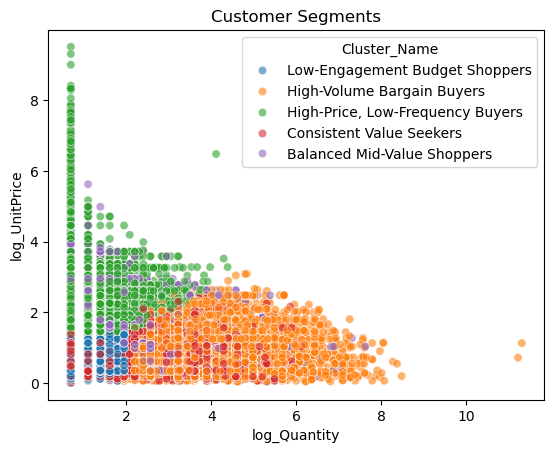

In [24]:
cluster_names = {
  "0": "Balanced Mid-Value Shoppers",
  "1": "High-Price, Low-Frequency Buyers",
  "2": "High-Volume Bargain Buyers",
  "3": "Low-Engagement Budget Shoppers",
  "4": "Consistent Value Seekers"
}


data['Cluster_Name'] = data['Cluster'].map(cluster_names)

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=data.to_pandas(),
    x='log_Quantity',
    y='log_UnitPrice',
    hue='Cluster_Name',
    alpha=0.6
)

plt.title("Customer Segments")
plt.show()



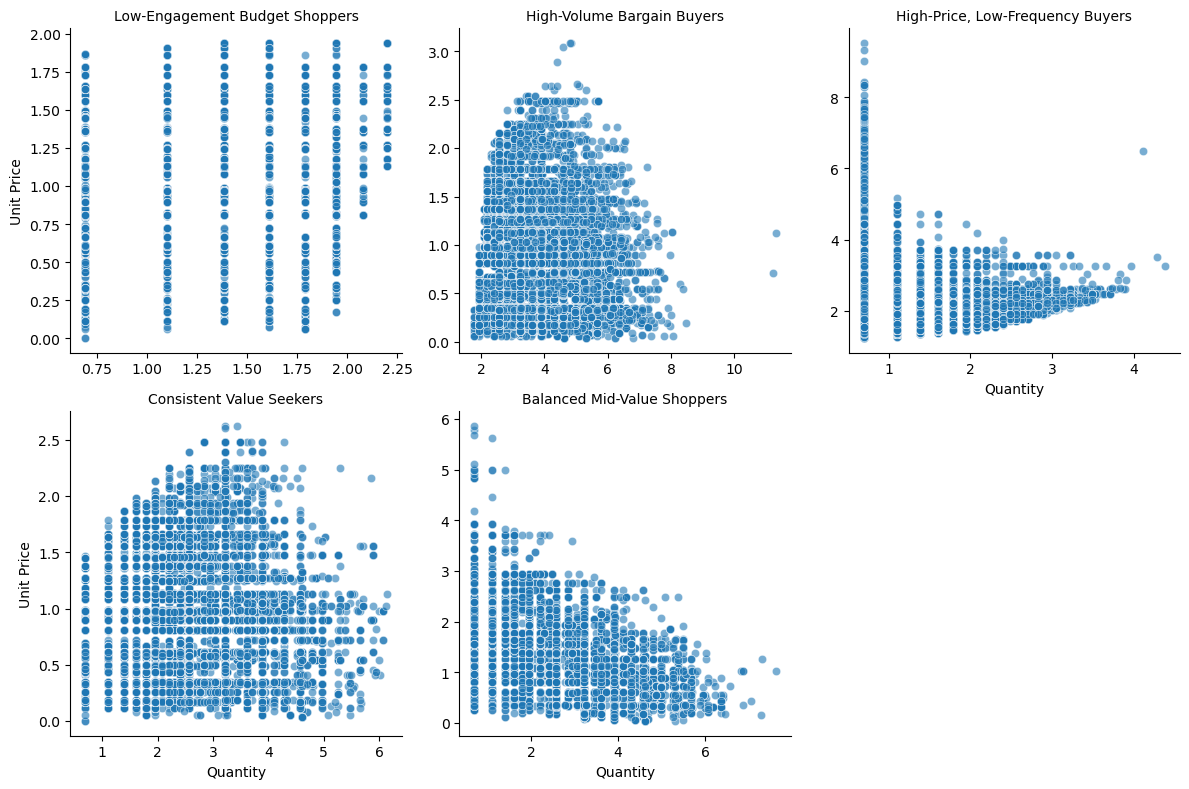

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(
    data.to_pandas(),
    col="Cluster_Name",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4
)

g.map_dataframe(
    sns.scatterplot,
    x="log_Quantity",
    y="log_UnitPrice",
    alpha=0.6
)

g.set_axis_labels("Quantity", "Unit Price")
g.set_titles("{col_name}")

plt.show()

## 7. Conclusion
This notebook demonstrated how to perform customer segmentation using clustering techniques. We evaluated the performance of different clustering algorithms and visualized the results using PCA. Based on the metrics, we concluded that KMeans provided the best results.